In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
ROOT = "/kaggle/input/underwater-plastic-pollution-detection/underwater_plastics"
train_images_dir = f"{ROOT}/train/images"
train_labels_dir = f"{ROOT}/train/labels"
valid_images_dir = f"{ROOT}/valid/images"
valid_labels_dir = f"{ROOT}/valid/labels"

class_names = ['Mask','can','cellphone','electronics','gbottle','glove',
               'metal','misc','net','pbag','pbottle','plastic',
               'rod','sunglasses','tire']
NUM_CLASSES = len(class_names)

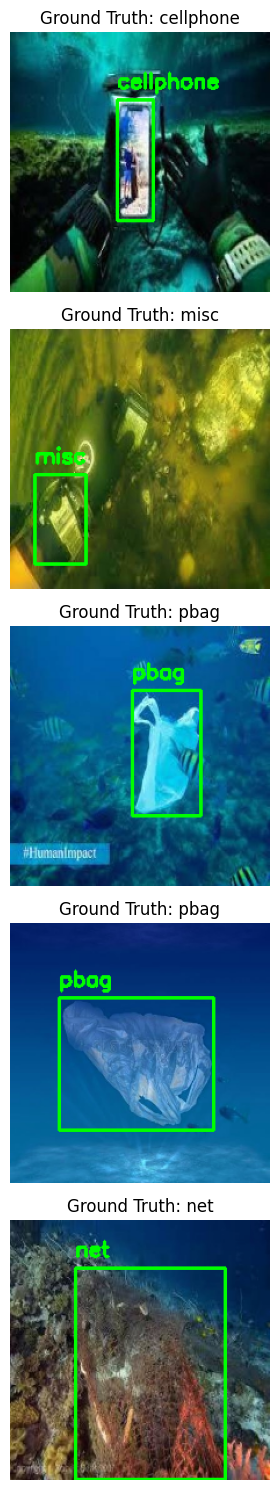

In [37]:
def show_ground_truth_samples(X, y_bboxes, y_classes, num=5):
    indices = np.random.choice(len(X), num, replace=False)
    plt.figure(figsize=(15, num * 3))
    for i, idx in enumerate(indices):
        img = (X[idx] * 255).astype(np.uint8)
        h, w = img.shape[:2]
        cx, cy, bw, bh = y_bboxes[idx]
        cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h
        x1, y1 = int(cx - bw / 2), int(cy - bh / 2)
        x2, y2 = int(cx + bw / 2), int(cy + bh / 2)

        img_copy = img.copy()
        class_id = np.argmax(y_classes[idx])
        label = class_names[class_id]
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_copy, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        plt.subplot(num, 1, i + 1)
        plt.imshow(img_copy)
        plt.axis('off')
        plt.title(f"Ground Truth: {label}")

    plt.tight_layout()
    plt.show()

show_ground_truth_samples(X_val, y_bbox_val, y_cls_val, num=5)


In [17]:
def load_images_one_box(img_dir, lbl_dir, img_size=(224,224)):
    images, bboxes, labels = [], [], []
    lb_encoder = LabelBinarizer().fit(range(NUM_CLASSES))

    for fname in os.listdir(img_dir):
        if not fname.endswith(".jpg"): continue
        img_path  = os.path.join(img_dir,  fname)
        lbl_path  = os.path.join(lbl_dir,  fname.replace(".jpg", ".txt"))
        if not os.path.exists(lbl_path):   continue

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        h, w = img.shape[:2]

        with open(lbl_path) as f:
            lines = f.readlines()
        if len(lines) == 0: continue

        best_line = max(lines, key=lambda ln: float(ln.split()[3])*float(ln.split()[4]))
        cls, cx, cy, bw, bh = map(float, best_line.split())
        bbox = [cx, cy, bw, bh] 

        images.append(img / 255.0)
        bboxes.append(bbox)
        labels.append(int(cls))

    images = np.array(images, dtype=np.float32)
    bboxes = np.array(bboxes, dtype=np.float32)
    labels = lb_encoder.fit_transform(labels)
    return images, bboxes, labels


In [18]:
X_train, y_bbox_train, y_cls_train = load_images_one_box(train_images_dir, train_labels_dir)
X_val,   y_bbox_val,   y_cls_val   = load_images_one_box(valid_images_dir,  valid_labels_dir)

print("Train:", X_train.shape, "  Val:", X_val.shape)

Train: (3626, 224, 224, 3)   Val: (1000, 224, 224, 3)


In [19]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers[:-20]: 
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
bbox_out  = layers.Dense(4, activation='sigmoid', name='bbox')(x)
class_out = layers.Dense(NUM_CLASSES, activation='softmax', name='class')(x)

model = Model(inputs=base_model.input, outputs=[bbox_out, class_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'bbox': 'mse', 'class': 'categorical_crossentropy'},
    metrics={'bbox': 'mae', 'class': 'accuracy'}
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,595,923 (9.90 MB)

 Trainable params: 1,541,459 (5.88 MB)

 Non-trainable params: 1,054,464 (4.02 MB)

In [21]:
history = model.fit(
    X_train,
    {'bbox': y_bbox_train, 'class': y_cls_train},
    validation_data=(X_val, {'bbox': y_bbox_val, 'class': y_cls_val}),
    epochs=40,
    batch_size=32
)



Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 154ms/step - bbox_mae: 0.2837 - class_accuracy: 0.2816 - loss: 2.8657 - val_bbox_mae: 0.2078 - val_class_accuracy: 0.5320 - val_loss: 1.9234
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - bbox_mae: 0.2733 - class_accuracy: 0.7426 - loss: 0.9647 - val_bbox_mae: 0.2237 - val_class_accuracy: 0.5740 - val_loss: 2.0839
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - bbox_mae: 0.2632 - class_accuracy: 0.8403 - loss: 0.6004 - val_bbox_mae: 0.2364 - val_class_accuracy: 0.6040 - val_loss: 2.0516
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - bbox_mae: 0.2538 - class_accuracy: 0.8904 - loss: 0.4367 - val_bbox_mae: 0.2344 - val_class_accuracy: 0.6410 - val_loss: 1.8362
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - bbox_mae: 0.2540 - class_accuracy: 0.9400 - loss: 0.3055 - val_bbox_mae: 0.2289 - val_class_accuracy: 0.6740 - val_loss: 1.6243
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - bbox_mae: 0.2496 - class_acc

In [22]:
def draw_pred(img, pred_bbox, pred_class_id):
    h, w, _ = img.shape
    cx, cy, bw, bh = pred_bbox
    cx, cy, bw, bh = cx*w, cy*h, bw*w, bh*h
    x1, y1 = int(cx - bw/2), int(cy - bh/2)
    x2, y2 = int(cx + bw/2), int(cy + bh/2)

    out = img.copy()
    cv2.rectangle(out, (x1,y1), (x2,y2), (255,0,0), 2)
    cv2.putText(out, class_names[pred_class_id], (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    plt.figure(figsize=(5,5)); plt.imshow(out); plt.axis('off'); plt.show()


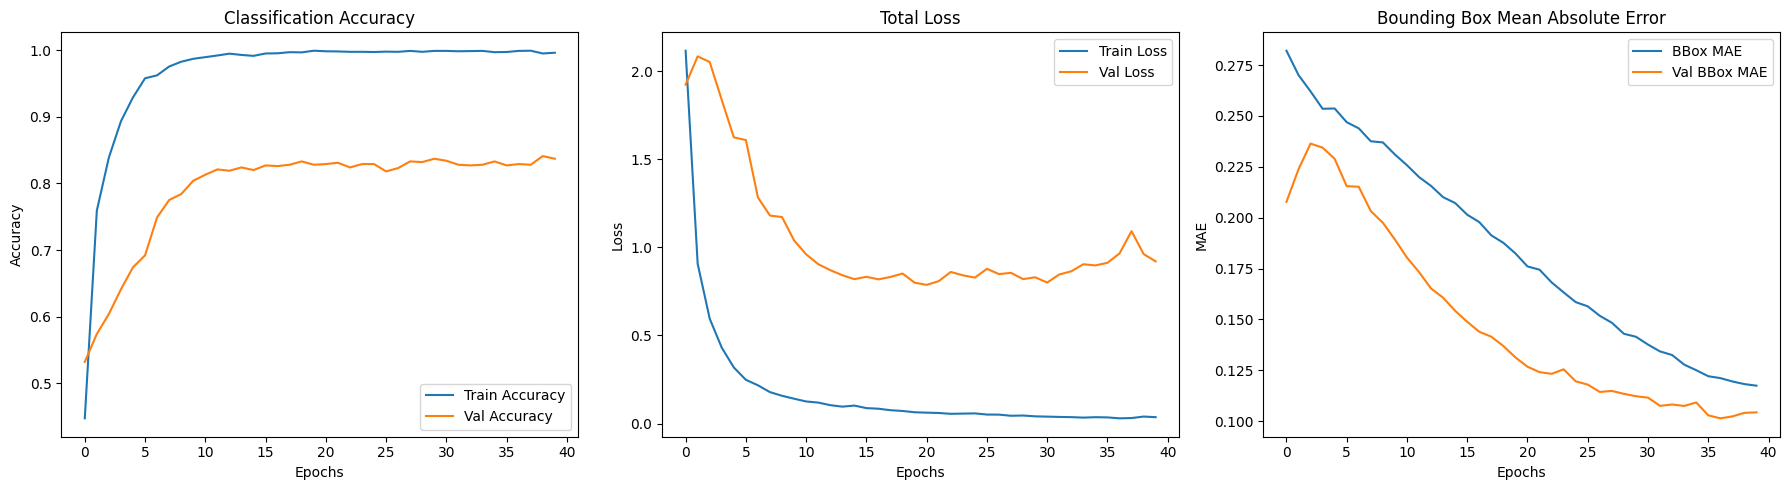

In [36]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['class_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['bbox_mae'], label='BBox MAE')
plt.plot(history.history['val_bbox_mae'], label='Val BBox MAE')
plt.title('Bounding Box Mean Absolute Error')
plt.xlabel('Epochs'); plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


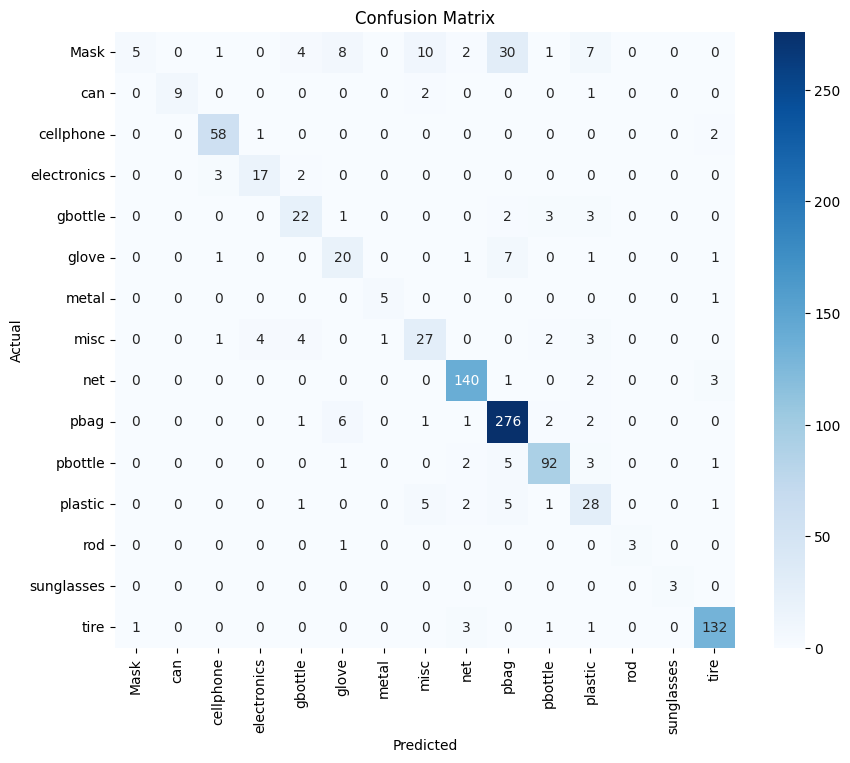


Classification Report:

              precision    recall  f1-score   support

        Mask       0.83      0.07      0.14        68
         can       1.00      0.75      0.86        12
   cellphone       0.91      0.95      0.93        61
 electronics       0.77      0.77      0.77        22
     gbottle       0.65      0.71      0.68        31
       glove       0.54      0.65      0.59        31
       metal       0.83      0.83      0.83         6
        misc       0.60      0.64      0.62        42
         net       0.93      0.96      0.94       146
        pbag       0.85      0.96      0.90       289
     pbottle       0.90      0.88      0.89       104
     plastic       0.55      0.65      0.60        43
         rod       1.00      0.75      0.86         4
  sunglasses       1.00      1.00      1.00         3
        tire       0.94      0.96      0.95       138

    accuracy                           0.84      1000
   macro avg       0.82      0.77      0.77      1000
w

In [35]:
true_cls = np.argmax(y_cls_val, axis=1)
pred_cls = np.argmax(model.predict(X_val)[1], axis=1)
cm = confusion_matrix(true_cls, pred_cls)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_cls, pred_cls, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


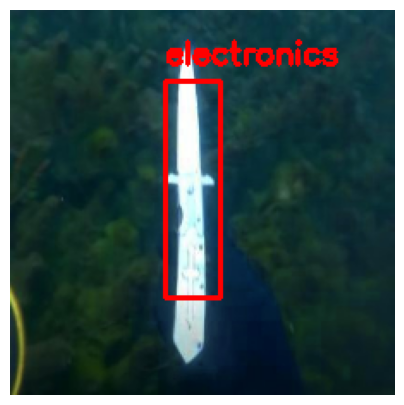

In [29]:
idx = 2 
img  = X_val[idx]
pred_bbox, pred_cls = model.predict(img[None, ...])
draw_pred((img*255).astype(np.uint8), pred_bbox[0], np.argmax(pred_cls))

In [40]:
model.save("/kaggle/working/underwater_pollution_model.h5")
print("Model saved to /kaggle/working/underwater_pollution_model.keras")


Model saved to /kaggle/working/underwater_pollution_model.keras
